In [1]:
import adi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fft as fft
import scipy.signal as sig
from scipy.signal import hann
from pandas import read_csv, DataFrame
import matplotlib as mpl
import functools
from timeit import default_timer as timer
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

In [2]:
golden_ratio = (np.sqrt(5) - 1) / 2
width = 10
height = width * golden_ratio

In [3]:
def sweep_signal(start_freq, end_freq, sweep_time, signal_amplitude):
    def harmonic(t):
        freq_sign = 1 if end_freq > start_freq else -1
    #     print(laser_switching_time + freq_sign * (end_freq - start_freq)  / atom_speed)
        if t < 0:
    #         print("turn on")
            return signal_amplitude * np.exp(2j*np.pi * start_freq * t)
        elif t < sweep_time:
    #         print("move", start_freq + freq_sign * atom_speed * local_t)
            return signal_amplitude * np.exp(2j*np.pi *(start_freq + (end_freq - start_freq)/sweep_time * t) * t)
        else:
    #         print("turn off", local_t)
            return signal_amplitude * np.exp(2j*np.pi * end_freq * t)
    return harmonic

def steady_signal(freq, signal_amplitude):
    def harmonic(t):
            return signal_amplitude * np.exp(2j*np.pi * freq * t)
    return harmonic

def get_averaged_spectrum(sdr, average=10):
    x_signal, y_signal = sdr.rx()
    x_spectrum = fft.fftshift(fft.fft(x_signal))
    y_spectrum = fft.fftshift(fft.fft(y_signal))
    for i in range(average-1):
        x_signal, y_signal = sdr.rx()
        x_spectrum = x_spectrum + fft.fftshift(fft.fft(x_signal))
        y_spectrum = y_spectrum + fft.fftshift(fft.fft(y_signal))
    x_spectrum = x_spectrum / average
    y_spectrum = y_spectrum / average
    frequencies = fft.fftshift(fft.fftfreq(x_signal.shape[0], 1 / sdr.sample_rate) + sdr.rx_lo) / 1e6
    x_spectrum = DataFrame(data = x_spectrum.imag**2 + x_spectrum.real**2, index = frequencies)
    y_spectrum = DataFrame(data = y_spectrum.imag**2 + y_spectrum.real**2, index = frequencies)
    return (x_spectrum, y_spectrum)

In [4]:
signal_amplitude = 2**10
start_freq = -1e6
end_freq = 1e6
sweep_time = 0.5e-3
sample_rate = int(20e6)
buff_size = int(2**15)
lo = int(99e6)
y_freq = 1e6

x = np.vectorize(sweep_signal(start_freq, end_freq, sweep_time, signal_amplitude))
y = np.vectorize(steady_signal(y_freq, signal_amplitude))
t = np.linspace(0, buff_size / sample_rate, buff_size)
x_signal = x(t)
y_signal = y(t)
zeros = np.zeros(buff_size)
print("Buffer time: {:.3f}ms, sweep time: {:.3f}ms".format(buff_size / sample_rate * 1e3, sweep_time * 1e3))

spectrum = np.abs(fft.fftshift(fft.fft(x_signal)))
frequencies = fft.fftshift(fft.fftfreq(x_signal.shape[0], 1 / sample_rate)) / 1e6

# plt.figure(figsize=[width,height])
# plt.plot(frequencies, spectrum)
# plt.yscale('log')
# plt.xlabel("МГц")
# # plt.axvline(101492256e-6)
# # plt.axvline(97840290e-6)
# # plt.xlim(-.5,.5)
# plt.grid(which='both')
# # plt.savefig('../TeX/figures/spectrum/Y_scaled.pdf', bbox_inches='tight')
# plt.show()

Buffer time: 1.638ms, sweep time: 0.500ms


# Работа с железом

In [5]:
sdr = adi.ad9361('ip:172.16.1.251')

In [6]:
sdr.tx_destroy_buffer()
sdr.rx_lo = lo
sdr.tx_lo = lo
sdr.sample_rate = sample_rate
sdr.rx_rf_bandwidth = int(1.6 * sdr.sample_rate / 2)
sdr.tx_rf_bandwidth = int(1.6 * sdr.sample_rate / 2)
sdr.gain_control_mode = "slow_attack"
sdr.tx_hardwaregain = 0 #14.5
sdr.tx_enabled_channels = [0,1]
sdr.rx_enabled_channels = [0,1]
sdr.tx_buffer_size = buff_size
sdr.rx_buffer_size = buff_size
# Подключение: TX2 - RX1
sdr.tx_destroy_buffer()
sdr.rx_destroy_buffer()
sdr.tx_cyclic_buffer = True
sdr.loopback = 0

In [7]:
sdr.tx_destroy_buffer()
# sdr.tx([x_signal,y_signal])
sdr.tx([y_signal,y_signal])
# sdr.tx([zeros,zeros])

In [8]:
x_measured_spectrum, y_measured_spectrum = get_averaged_spectrum(sdr, 1)
x_generated_spectrum_ = fft.fftshift(fft.fft(x_signal))
y_generated_spectrum_ = fft.fftshift(fft.fft(y_signal))
frequencies = fft.fftshift(fft.fftfreq(x_signal.shape[0], 1 / sdr.sample_rate) + sdr.rx_lo) / 1e6
x_generated_spectrum = DataFrame(data = x_generated_spectrum_.imag**2 + x_generated_spectrum_.real**2, index = frequencies)
y_generated_spectrum = DataFrame(data = y_generated_spectrum_.imag**2 + y_generated_spectrum_.real**2, index = frequencies)
# generated_spectrum = generated_spectrum / generated_spectrum.max()
x_measured_spectrum_norm = x_measured_spectrum / x_measured_spectrum.mean()
y_measured_spectrum_norm = y_measured_spectrum / y_measured_spectrum.mean()
x_generated_spectrum_norm = x_generated_spectrum / x_generated_spectrum.mean()
y_generated_spectrum_norm = y_generated_spectrum / y_generated_spectrum.mean()

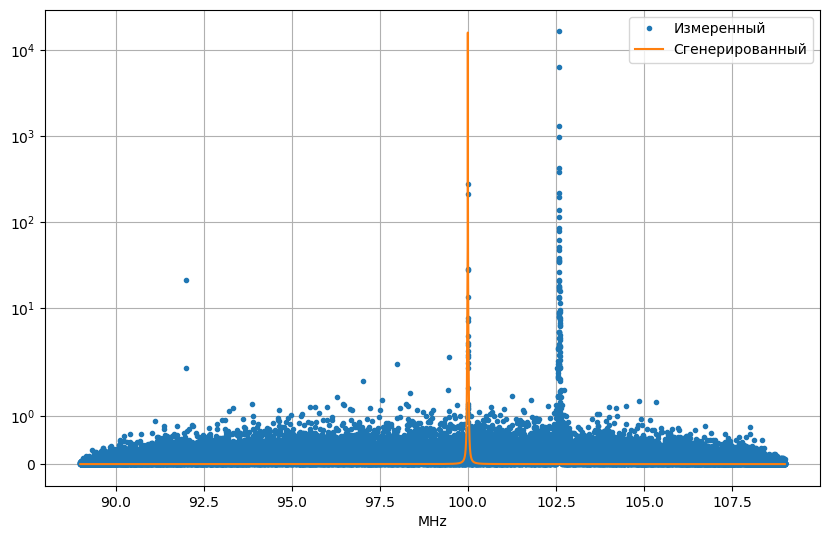

In [9]:
plt.figure(figsize=[width,height])
plt.plot(x_measured_spectrum_norm, ".", label="Измеренный")
plt.plot(y_generated_spectrum_norm, label="Сгенерированный")
plt.yscale('symlog')
plt.grid("both")
plt.xlabel("MHz")
# plt.ylabel("dB")
plt.legend()
# plt.ylabel("dB")
# plt.savefig('../TeX/figures/spectrum/X_measured_norm.pdf', bbox_inches='tight')
plt.show()

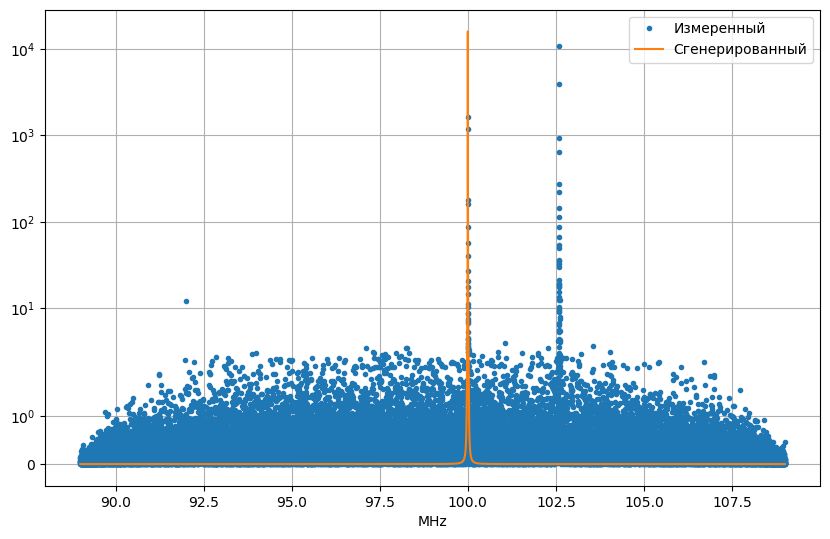

In [10]:
plt.figure(figsize=[width,height])
plt.plot(y_measured_spectrum_norm, ".", label="Измеренный")
plt.plot(y_generated_spectrum_norm, label="Сгенерированный")
plt.yscale('symlog')
plt.grid()
plt.xlabel("MHz")
# plt.ylabel("dB")
plt.legend()
# plt.ylabel("dB")
# plt.savefig('../TeX/figures/spectrum/X_measured_norm.pdf', bbox_inches='tight')
plt.show()

In [11]:
sdr.tx_destroy_buffer()
del sdr

In [12]:
# help(adi.ad9361)